<a href="https://colab.research.google.com/github/amilsiddik/Deep-Learning/blob/main/Ansemble_VGG_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Penelitian/Deteksi hand sign/Dataset"
key_value= dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path+'/'+i)

In [4]:
df = []
for key in key_value.keys():
    for j in key_value[key]:
        df.append([key,path+'/'+key+'/'+j])
df1 = pd.DataFrame(df,columns=('label','path'))
df1

,label,path
0,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
1,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
2,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
3,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
4,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
...,...,...
2057,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2058,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2059,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2060,7,/content/drive/MyDrive/Penelitian/Deteksi hand...


In [5]:
def readimg(path):
    img= cv.imread(path)
    img = cv.resize(img,(224,224))
    return img

In [6]:
import multiprocessing

# Create a Pool with 4 worker processes
with multiprocessing.Pool(4) as p:
    # Read in all of the images in parallel
    images = p.map(readimg, df1['path'])

In [7]:
images=np.array(images, dtype='float')
# label encoder from sklearn
le = preprocessing.LabelEncoder()
y_labels = le.fit_transform(df1['label'])

In [8]:
# to split the data into training and testing data
train_images,test_images,train_labels,test_labels = train_test_split(images,y_labels,test_size=0.25, random_state=42)

In [9]:
## implementing trensfer learning
resnet_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freezing the base model so we donot have to train it again
resnet_model.trainable = False

# Load the VGG19 model
vgg_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

input_layer = keras.layers.Input(shape=(224, 224, 3))
vgg_output = vgg_model(input_layer)
resnet_output = resnet_model(input_layer)
merged_output = keras.layers.Concatenate()([vgg_output, resnet_output])
global_avg_pool = keras.layers.GlobalAveragePooling2D()(merged_output)
dense_layer = keras.layers.Dense(1024, activation='relu')(global_avg_pool)
output_layer = keras.layers.Dense(10, activation='softmax')(dense_layer)

model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the ensemble model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


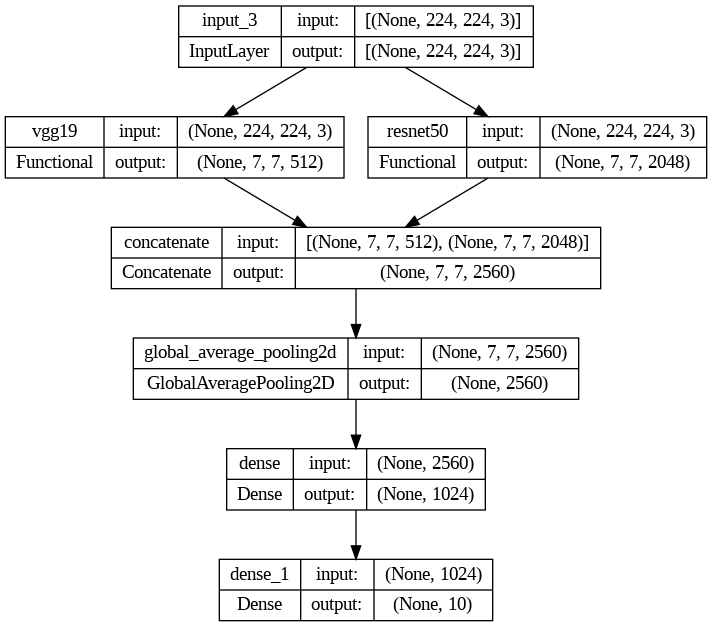

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_3[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 7, 7, 2560)   0           ['vgg19[0][0]',              

In [11]:
history = model.fit(train_images,train_labels, epochs=50, batch_size=32,validation_data=(test_images, test_labels))

Epoch 1/50
49/49 [==============================] - 40s 421ms/step - loss: 1.6515 - accuracy: 0.6960 - val_loss: 0.2748 - val_accuracy: 0.9109
Epoch 2/50
49/49 [==============================] - 17s 342ms/step - loss: 0.1939 - accuracy: 0.9373 - val_loss: 0.1908 - val_accuracy: 0.9302
Epoch 3/50
49/49 [==============================] - 17s 347ms/step - loss: 0.1120 - accuracy: 0.9715 - val_loss: 0.1507 - val_accuracy: 0.9457
Epoch 4/50
49/49 [==============================] - 17s 356ms/step - loss: 0.0731 - accuracy: 0.9825 - val_loss: 0.1142 - val_accuracy: 0.9574
Epoch 5/50
49/49 [==============================] - 18s 365ms/step - loss: 0.0305 - accuracy: 0.9961 - val_loss: 0.1160 - val_accuracy: 0.9554
Epoch 6/50
49/49 [==============================] - 18s 367ms/step - loss: 0.0258 - accuracy: 0.9961 - val_loss: 0.1215 - val_accuracy: 0.9535
Epoch 7/50
49/49 [==============================] - 16s 338ms/step - loss: 0.0263 - accuracy: 0.9968 - val_loss: 0.1172 - val_accuracy: 0.9709

17/17 [==============================] - 5s 245ms/step


Text(0.5, 1.0, 'Confusion Matrix')

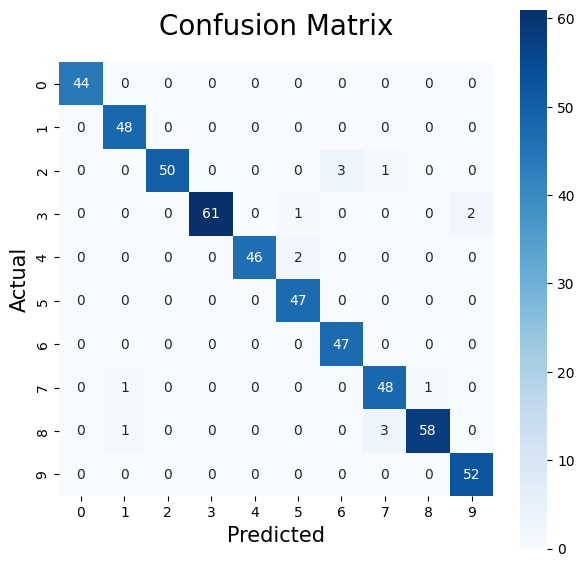

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Menampilkan Confusion Matrix
numer_type = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
Y_pred = model.predict(test_images)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = test_labels

fig, ax = plt.subplots(figsize=(7,7))
cm = confusion_matrix(Y_true, Y_pred)
#plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True,
                 square=True, xticklabels=numer_type,
                 yticklabels=numer_type, ax=ax)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xlabel('Predicted', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=20, pad=20)

In [13]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predictions to the class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the accuracy score
accuracy = accuracy_score(test_labels, predicted_labels)

print('Accuracy:', accuracy)

17/17 [==============================] - 4s 248ms/step
Accuracy: 0.9709302325581395


In [14]:
from sklearn.metrics import precision_score

precision = precision_score(test_labels, predicted_labels, average='macro')

print('Precision:', precision)

Precision: 0.9709090733497513


In [15]:
from sklearn.metrics import recall_score

recall= recall_score(test_labels, predicted_labels, average='macro')

print('Recall:', recall)

Recall: 0.9732868130227


In [16]:
from sklearn.metrics import f1_score

f1= f1_score(test_labels, predicted_labels, average='macro')

print('F1-Score:', f1)

F1-Score: 0.9714984264435728


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Text(0.5, 1.0, 'Accuracy Vs Epoch')

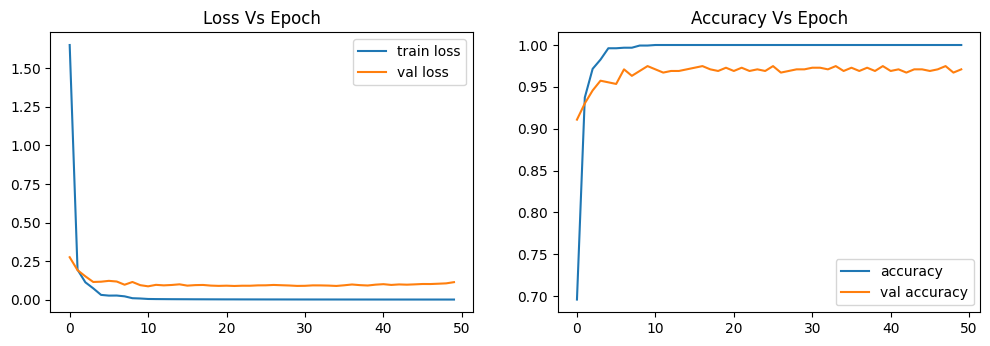

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Vs Epoch')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy Vs Epoch')

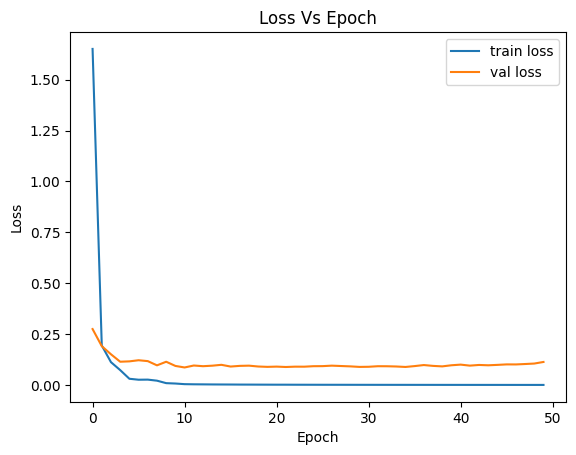

In [18]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

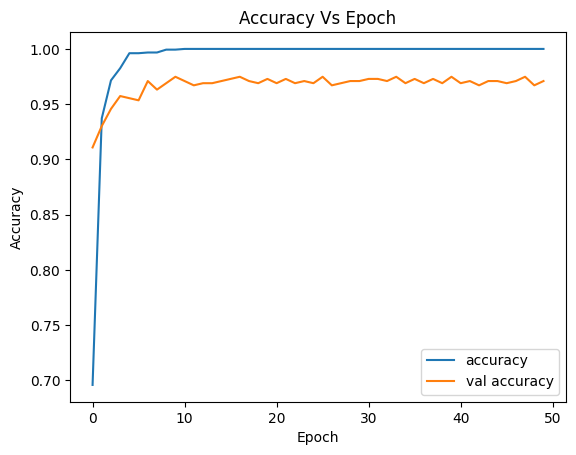

In [19]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy Vs Epoch')
plt.show()

In [22]:
from sklearn.metrics import classification_report
pred = model.predict(test_images, verbose=1)
model_predicted = np.argmax(pred, axis = 1)

File=[]
for file in os.listdir(path):
    File+=[file]
print(File)
#print(classification_report(test_labels.argmax(axis=1), model_predicted, target_names=File))

17/17 [==============================] - 4s 246ms/step
['6', '8', '3', '4', '0', '5', '1', '9', '2', '7']


In [23]:
test_images[1]
#Y_pred = model.predict(test_images[1])

array([[[122., 123., 127.],
        [121., 122., 126.],
        [121., 122., 126.],
        ...,
        [123., 121., 121.],
        [126., 123., 125.],
        [125., 123., 123.]],

       [[121., 122., 126.],
        [123., 124., 128.],
        [123., 124., 128.],
        ...,
        [125., 121., 122.],
        [123., 120., 122.],
        [123., 121., 121.]],

       [[120., 121., 125.],
        [114., 115., 119.],
        [124., 125., 129.],
        ...,
        [128., 123., 124.],
        [124., 122., 122.],
        [130., 125., 126.]],

       ...,

       [[125., 126., 130.],
        [124., 127., 131.],
        [123., 126., 130.],
        ...,
        [122., 123., 127.],
        [119., 121., 122.],
        [119., 121., 122.]],

       [[124., 127., 131.],
        [124., 128., 129.],
        [126., 129., 133.],
        ...,
        [122., 124., 125.],
        [123., 125., 126.],
        [122., 124., 125.]],

       [[122., 125., 129.],
        [122., 127., 130.],
        [125., 1

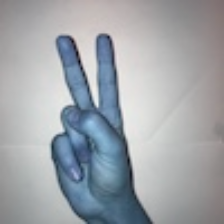

In [40]:
from PIL import Image

# Matriks gambar
image_array = test_images[6]

# Konversi array menjadi gambar
image = Image.fromarray(image_array.astype(np.uint8))

# Menampilkan gambar
image.show()

In [34]:
# Menggunakan model untuk memprediksi gambar
predicted_labels = model.predict(test_images)

# Mengubah hasil prediksi menjadi label kelas
predicted_classes = np.argmax(predicted_labels, axis=1)

# Menampilkan hasil prediksi
print(predicted_classes)


17/17 [==============================] - 4s 251ms/step
[1 1 4 7 6 5 2 3 5 7 0 7 9 7 4 4 6 5 6 9 6 2 3 1 7 3 9 4 5 7 2 5 0 1 0 1 4
 8 7 3 9 9 3 8 8 3 6 9 2 7 8 7 1 3 8 6 1 2 3 2 6 9 3 9 5 7 3 5 1 0 8 8 5 9
 0 7 7 0 4 2 2 7 3 6 7 6 6 0 8 5 5 0 9 0 9 0 3 3 2 9 3 6 7 6 3 8 9 6 2 9 3
 2 4 4 8 3 1 8 5 5 5 6 8 5 2 3 1 5 8 6 4 8 7 7 2 4 2 7 3 3 3 1 3 1 1 8 1 3
 5 0 7 3 8 3 1 9 1 5 8 8 9 5 7 2 1 3 0 9 1 7 2 9 3 7 8 1 9 1 6 1 8 9 0 2 0
 4 3 3 0 3 2 1 6 4 3 6 2 2 2 5 0 9 6 2 3 0 3 5 5 2 7 6 3 2 5 4 8 4 5 6 1 0
 1 8 9 5 0 8 7 5 2 0 9 1 5 8 5 0 1 0 7 1 8 6 7 6 8 3 4 7 3 0 5 6 6 2 3 5 7
 3 0 9 7 2 4 9 4 9 9 8 8 8 2 7 5 9 9 4 8 9 5 4 5 7 8 7 3 7 2 4 6 9 6 2 6 1
 5 3 8 6 6 4 4 3 2 4 3 7 1 8 1 1 8 7 7 0 1 4 6 5 5 2 6 6 8 3 2 7 4 8 6 0 8
 1 3 6 7 9 7 0 2 4 1 6 5 7 8 5 5 9 0 9 9 2 2 8 6 9 6 8 8 7 8 7 7 9 5 0 1 3
 5 4 8 7 7 5 0 6 1 0 9 2 8 0 1 4 7 7 7 9 1 6 3 2 1 2 6 2 8 3 3 6 5 3 8 3 6
 5 4 2 8 1 8 5 7 1 6 2 3 4 4 9 1 9 2 0 0 2 2 2 0 0 9 0 4 9 9 2 1 4 3 4 4 7
 8 9 5 8 5 0 4 5 9 3 8 5 1 9 4 4 2 6 2 8 6 6 

In [ ]:
test_images

array([[[[128., 123., 124.],
         [128., 123., 124.],
         [129., 123., 124.],
         ...,
         [114., 107., 107.],
         [114., 106., 106.],
         [114., 106., 106.]],

        [[128., 123., 124.],
         [128., 123., 124.],
         [129., 124., 125.],
         ...,
         [115., 107., 107.],
         [114., 106., 106.],
         [114., 106., 106.]],

        [[128., 123., 125.],
         [129., 124., 125.],
         [129., 124., 126.],
         ...,
         [115., 107., 107.],
         [115., 107., 107.],
         [115., 106., 106.]],

        ...,

        [[112., 110., 110.],
         [112., 110., 110.],
         [113., 111., 111.],
         ...,
         [ 92.,  90.,  90.],
         [ 92.,  90.,  90.],
         [ 92.,  90.,  90.]],

        [[111., 109., 109.],
         [111., 109., 109.],
         [112., 110., 110.],
         ...,
         [ 91.,  88.,  88.],
         [ 91.,  88.,  88.],
         [ 91.,  88.,  88.]],

        [[111., 109., 109.],
       